In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
import operator
import re
import calendar
from collections import Counter
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 9,5
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

def get_cmap(target_len):
    jet = cm = plt.get_cmap('rainbow')
    cNorm  = colors.Normalize(vmin=0, vmax=len(target_len))
    return 0,cmx.ScalarMappable(norm=cNorm, cmap=jet)

In [2]:
data = pd.read_pickle('master_VGC22')

In [3]:
def clean_date(date):
    try:
        dmy = re.split(' ',date)
        d = int(dmy[0][:-2])
        nametonum = {v: k for k,v in enumerate(calendar.month_abbr)}
        m = nametonum[dmy[1]]
        if dmy[2][0] == '0' or dmy[2][0] == '1':
            y = int('20'+dmy[2])
        else:
            y = int('19'+dmy[2])
        return d,m,y
    except:
        return None,None,None
cdate = [clean_date(date) for date in list(data.Date)]
data['Day'],data['Month'],data['Year']=zip(*cdate)

In [4]:
def clean_units(data,key_):
    dataNA = []
    for i in list(data[key_]):
        if type(i) == str:
            dataNA.append(0)
        else:
            dataNA.append(float(i))
    return dataNA
for reg in  ['NA','JAP','Other','PAL']:
    data[reg] = clean_units(data,reg)

data['WW'] = [sum([float(i) for i in k if i > 0]) for k in data[['JAP','NA','Other','PAL']].values]

In [5]:
len(data[data.NA > 0])

18549

In [6]:
iiigen = data[data.Year < 1993]
iiigen = iiigen[iiigen.Year > 1983]
cons = ['5200','7800', 'ACPC', 'AST', 'Aco', 'Amig', 'Arc', 'BBCM', 'BRW', 'C128', 'C64', 'MS', 'MSX', 'NES', 'PCE', 'TG16', 'ZXS']
iiigen = iiigen[iiigen.Console.isin(cons)]

devs_in_time = {}
for c in set(iiigen.Console):
    devs_in_time[c] = []    
    consdf = iiigen[iiigen.Console == c]
    mint = min(consdf.Year)
    maxt = max(consdf.Year)
    devs_in_time[c] = [len(set(consdf[consdf.Year == y].Developer)) for y in range(1983,1989)]

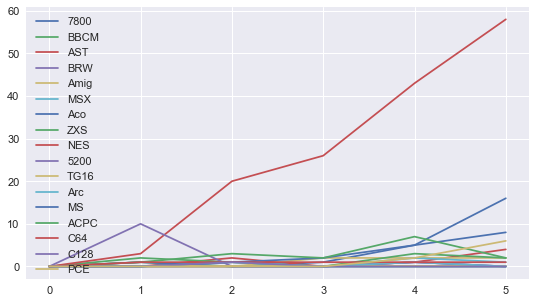

In [7]:
for i in devs_in_time.keys():
    plt.plot(devs_in_time[i],label=i)
plt.legend(loc=2)
plt.show()
    

In [8]:
#get total games released by developer for first 11 years (for all consoles)
totaldf = {}

datan = data[data.Year > 1972]

for c in set(datan.Console):
    nes = datan[datan.Console == c]
    
    #get rid of None years
    yrs = list(nes.Year)
    mint = min(yrs)
    if mint == None:
        mint = 0
    maxt = max(yrs)

    nesdev = pd.DataFrame.from_dict(Counter(nes.Publisher),orient='index')#,index=range(len(set(nes.Developer))))

    nesdev = nesdev.sort_values(by=0,ascending=False)

    nesdevn = {str(i):[] for i in nesdev.index}

    for n in nesdevn.keys():
        nesn = nes[nes.Publisher == n]
        tot = [len(set(nesn[nesn.Year == y].Game)) for y in range(mint,mint+11)]
        ww = [i for i in list(nesn.WW) if i > 0]
        totaldf[len(totaldf)] = [c]+[n]+tot+[sum(tot),sum(ww)]
tdf = pd.DataFrame.from_dict(totaldf,orient='index')
tdf.columns = ['Console','Publisher']+[str(i) for i in range(1,12)]+['Releases','Sold']
tdf = tdf.sort_values(by='Releases',ascending=False)


In [9]:
home_console = [u'CD32', u'SAT', u'7800', u'GC', u'S32X', u'GEN', u'2600',
                u'FDS', u'PS2', u'PS3', u'PS4', u'PCE', u'PS', u'SCD', u'TG16',
                u'SNES', u'XOne', u'Odys', u'MS', u'NES', u'N64',
                u'NG', u'NS', u'XB', u'CDi', u'WiiU', u'3DO',u'DC',
                u'Ouya', u'X360', u'AJ',
                u'5200', u'BBCM', u'Wii']

generations = {1:[u'Odys'],
              2:[u'2600','5200'],
              3:[u'7800',u'MS',u'NES'],
              4:[u'PCE',u'SCD',u'TG16',u'GEN',u'SNES',u'NG',u'CDi'],
              5:[u'CD32',u'SAT',u'S32X',u'PS',u'N64',u'3DO',u'AJ'],
              6:[u'GC',u'PS2',u'XB',u'DC',u'iQue'],
              7:[u'PS3',u'X360',u'Wii'],
              8:[u'PS4',u'XOne',u'WiiU',u'NS',u'Ouya']}

console_gen = {}
for con in home_console:
    for g,cons in generations.items():
        if con in cons:
            console_gen[con] = g
    
#generations = {'I':['Odys'],
#              'II':['2600','5200'],
#              'III':['7800','MS','NES','C64'],
#              'IV':['PCE','GEN','SNES','TG16','SCD','CDi','TG16','NG'],
#              'V':['CD32','AJ','PS','SAT','S32X','N64'],
#              'VI':['GC','XB','PS2','iQue','DC'],
#              'VII':['X360','Wii','PS3'],
#              'VIII':['Ouya','PS4','WiiU','NS']}

In [10]:
gens_describe = {i:[] for i in ['Generation','N','Platforms','Games','Publishers','Developers','Sales']}
for g in range(2,9):
    d = data[data.Console.isin(generations[g])]
    gens_describe['Generation'].append(str(g))
    gens_describe['N'].append(str(len(d)))
    gens_describe['Platforms'].append(str(len(generations[g])))
    gens_describe['Games'].append(str(len(d)))
    gens_describe['Publishers'].append(str(len(set(d.Publisher))))
    gens_describe['Developers'].append(str(len(set(d.Developer))))
    gens_describe['Sales'].append(str(sum([float(i) for i in d.WW if i > 0])))

In [11]:
gen_df = pd.DataFrame.from_dict(gens_describe,orient='columns')
gen_df.index = range(2,9)

In [12]:
gen_df

,Developers,Games,Generation,N,Platforms,Publishers,Sales
2,104,573,2,573,2,51,193.15
3,348,1494,3,1494,3,132,506.43
4,633,2868,4,2868,7,239,465.67
5,1071,4212,5,4212,7,406,1937.11
6,1164,5883,6,5883,5,350,3276.38
7,1134,5269,7,5269,3,336,5420.14
8,810,2979,8,2979,5,477,1801.12


In [13]:
def get_developer_behavior(include_this,g='Not specified'):
    nes = tdf[tdf.Console.isin(include_this)]

    print 'Results for generation '+str(g)
    
 #table head
    print str(len(nes[nes.Releases > 20]))+' firms with more than 20 releases'
    print str(len(nes[nes.Releases.isin(range(5,20))]))+' firms between 5 and 20'
    print str(len(nes[nes.Releases < 5]))+' firms with less than 5 releases\n\n'

 #statistics
    print nes.describe()
    


 #plot correlation and regression between Releases and Units sold
    sns.jointplot('Releases','Sold',data=nes,kind="reg")
    plt.show()

 #plot game release distribution   
    plt.bar(np.arange(1,104),[len(nes[nes.Releases == i]) for i in np.arange(1,104)],width=1)
    plt.xlabel('Releases')
    plt.ylabel('Frequency')
    plt.title('Game release distribution')
    plt.show()
    
 #same plot under loglog scale
    plt.scatter(np.arange(1,104),[len(nes[nes.Releases == i]) for i in np.arange(1,104)])
    plt.plot([len(nes[nes.Releases == i]) for i in np.arange(1,104)],c='w',linewidth=0)
    plt.title('Log-log plot of game releases')
    plt.loglog()
    plt.show()

 #plot the yearly amount of releases by category (>20,5-20,<5)
    avg = []
    print sum(list(nes.Releases))
    for k in nes[nes.Releases > 20].values:
        avg.append(k[2:12])

    avgar = np.array(avg, dtype=np.float64)

    avg20 = np.average(avgar, axis=0)
    plt.plot(avg20,label='> 20',c='r')

    #stdev = np.std(avgar, axis=0)
    #plt.plot(map(lambda x,y: x+y,avg,stdev),'--',label='> 20',c='r')
    #plt.plot(map(lambda x,y: x-y,avg,stdev),'--',label='> 20',c='r')

    avg = []
    for k in nes[nes.Releases.isin(range(5,20))].values:
        avg.append(k[2:12])
    avgar = np.array(avg)
    plt.plot(np.average(avgar, axis=0),label='20 - 5')

    avg = []
    for k in nes[nes.Releases < 5].values:
        avg.append(k[2:12])
    avgar = np.array(avg)
    plt.plot(np.average(avgar, axis=0),label='< 5')

    plt.legend(loc=1)
    plt.xlabel('Platform years')
    plt.ylabel('Releases')
    plt.xticks(np.arange(0,10),np.arange(1,11))
    plt.title('Game releases by firm category')
    plt.show()
    
    return avg20

Results for generation 2
4 firms with more than 20 releases
19 firms between 5 and 20
34 firms with less than 5 releases


               1          2          3          4          5          6  \
count  58.000000  58.000000  58.000000  58.000000  58.000000  58.000000   
mean    0.189655   0.913793   0.689655   0.551724   0.344828   2.500000   
std     1.083479   4.816946   2.458119   1.512201   1.291697   4.321509   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.000000   0.000000   0.000000   3.000000   
max     8.000000  35.000000  16.000000   8.000000   6.000000  18.000000   

               7          8          9         10         11    Releases  \
count  58.000000  58.000000  58.000000  58.000000  58.000000   58.000000   
mean    3.086207   0.413793   0.017241   0.034483

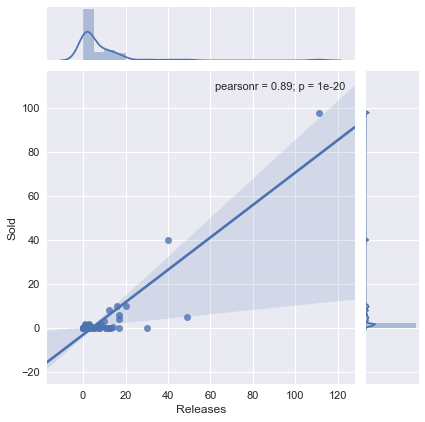

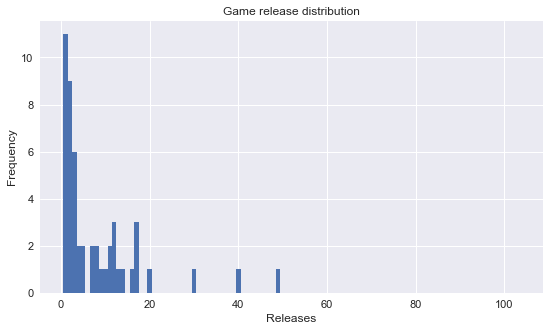

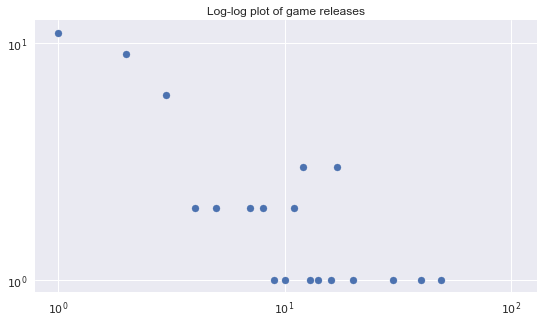

516


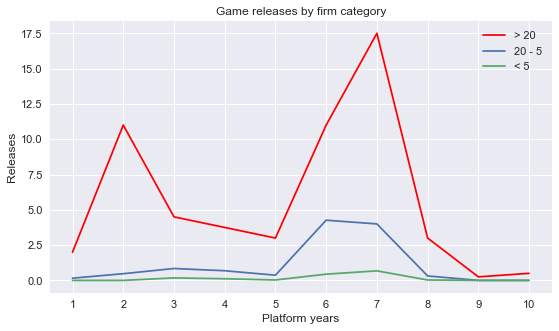

Results for generation 3
15 firms with more than 20 releases
49 firms between 5 and 20
81 firms with less than 5 releases


                1           2           3           4           5           6  \
count  145.000000  145.000000  145.000000  145.000000  145.000000  145.000000   
mean     0.062069    0.324138    0.634483    0.786207    1.000000    0.986207   
std      0.444420    2.535533    3.229237    3.857147    2.927361    2.590008   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
max      4.000000   26.000000   31.000000   43.000000   23.000000   20.000000   

                7           8           9          10          11    Releases  \
count  145.000000  145.000000  145.000000  145.000000  145.000000

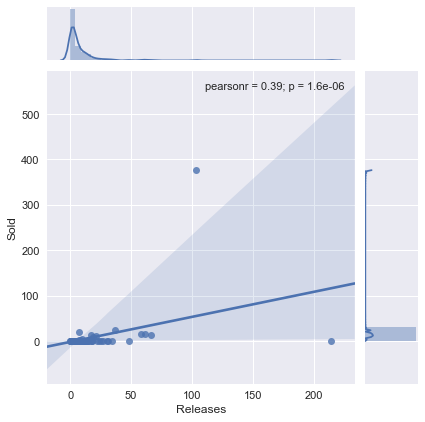

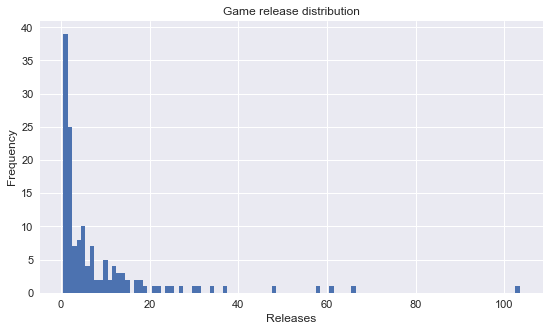

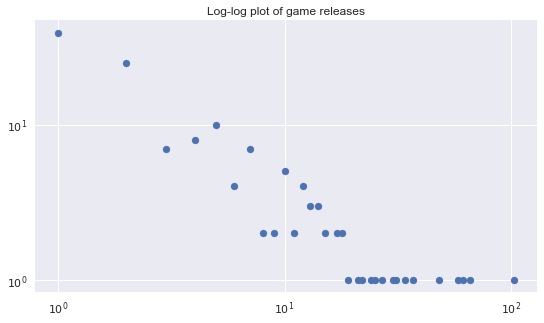

1420


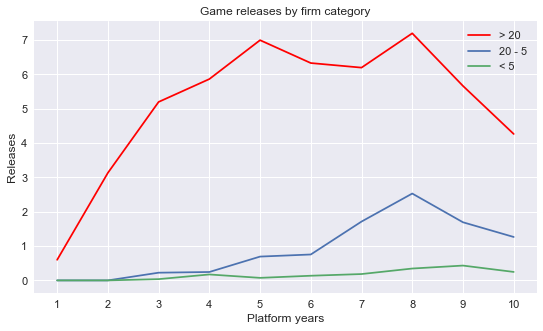

Results for generation 4
25 firms with more than 20 releases
110 firms between 5 and 20
258 firms with less than 5 releases


                1           2           3           4           5           6  \
count  394.000000  394.000000  394.000000  394.000000  394.000000  394.000000   
mean     0.073604    0.065990    0.218274    0.494924    0.654822    0.878173   
std      0.874963    0.717439    1.249151    2.250524    2.575603    2.660689   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
max     17.000000   12.000000   20.000000   26.000000   28.000000   35.000000   

                7           8           9          10          11    Releases  \
count  394.000000  394.000000  394.000000  394.000000  394.0000

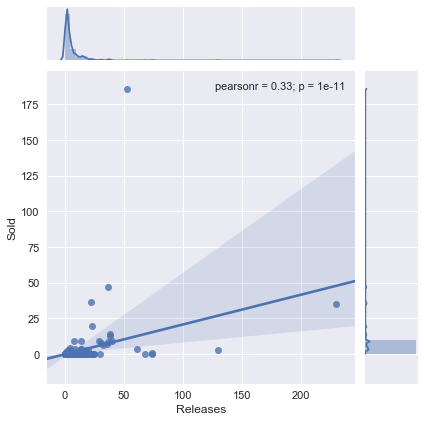

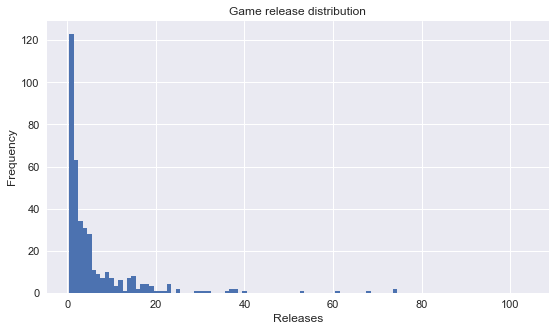

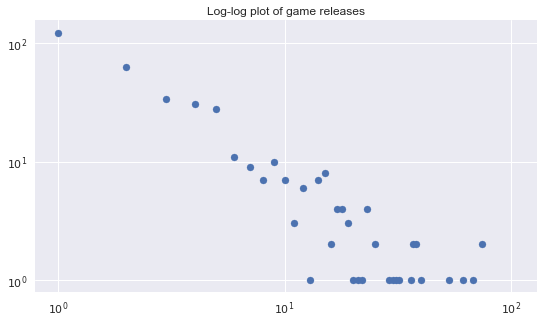

2768


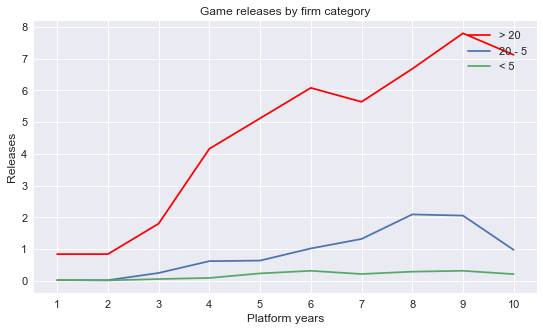

Results for generation 5
16 firms with more than 20 releases
79 firms between 5 and 20
567 firms with less than 5 releases


                1           2           3           4           5           6  \
count  662.000000  662.000000  662.000000  662.000000  662.000000  662.000000   
mean     0.058912    0.453172    0.802115    0.569486    0.320242    0.040785   
std      0.374494    1.811064    2.773081    1.828627    1.442865    0.274754   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
max      6.000000   34.000000   47.000000   32.000000   26.000000    5.000000   

                7           8           9          10          11    Releases  \
count  662.000000  662.000000  662.000000  662.000000  662.00000

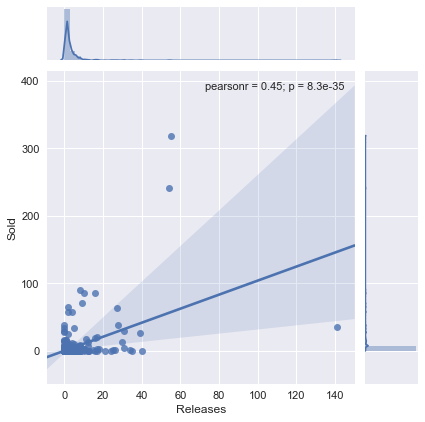

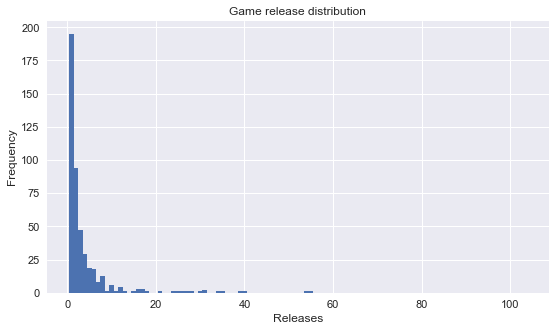

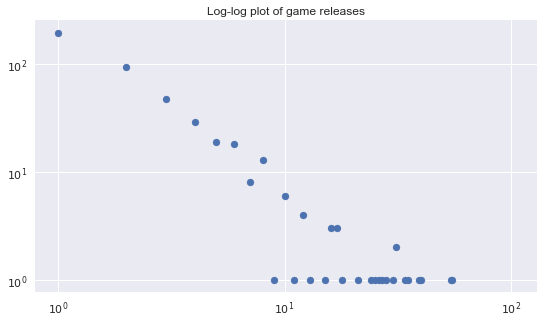

1917


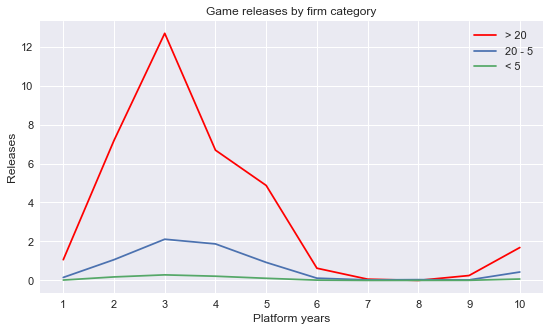

Results for generation 6
66 firms with more than 20 releases
136 firms between 5 and 20
379 firms with less than 5 releases


                1           2           3          4           5           6  \
count  585.000000  585.000000  585.000000  585.00000  585.000000  585.000000   
mean     0.232479    1.182906    1.735043    1.57265    1.444444    1.162393   
std      0.934849    3.058625    4.260348    3.99468    3.690613    3.273904   
min      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
75%      0.000000    1.000000    1.000000    1.00000    1.000000    1.000000   
max     12.000000   34.000000   61.000000   47.00000   38.000000   33.000000   

                7           8           9          10          11    Releases  \
count  585.000000  585.000000  585.000000  585.000000  585.000000  585.0

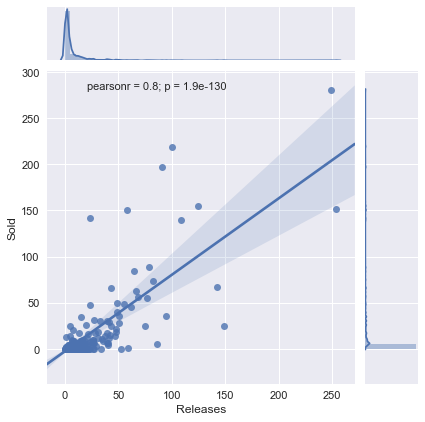

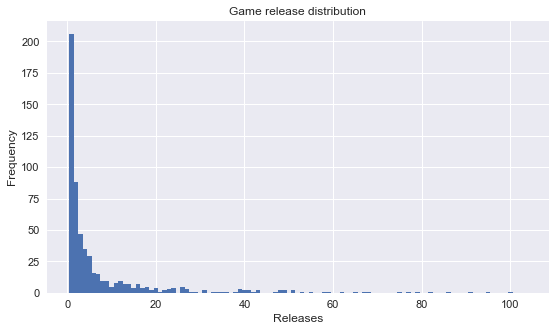

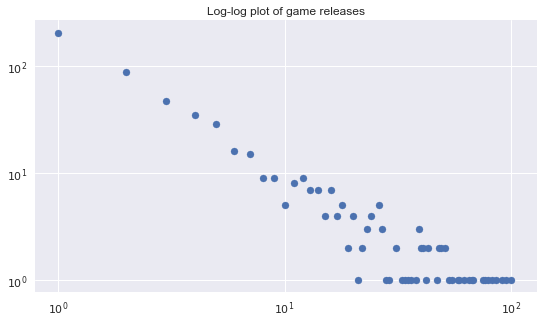

5731


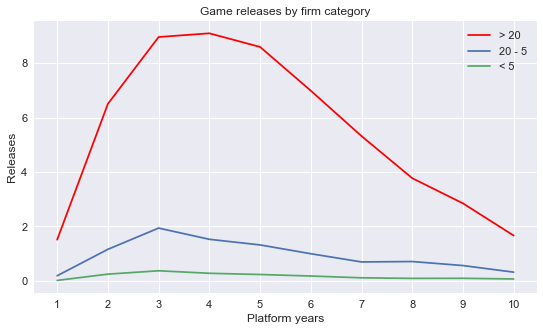

Results for generation 7
63 firms with more than 20 releases
101 firms between 5 and 20
375 firms with less than 5 releases


                1           2           3           4           5           6  \
count  542.000000  542.000000  542.000000  542.000000  542.000000  542.000000   
mean     0.151292    0.726937    1.142066    1.343173    1.289668    1.243542   
std      0.648607    2.150350    3.053455    3.423894    3.308400    3.165740   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    1.000000    1.000000    1.000000    1.000000   
max      7.000000   16.000000   28.000000   32.000000   27.000000   31.000000   

                7           8           9          10          11    Releases  \
count  542.000000  542.000000  542.000000  542.000000  542.0000

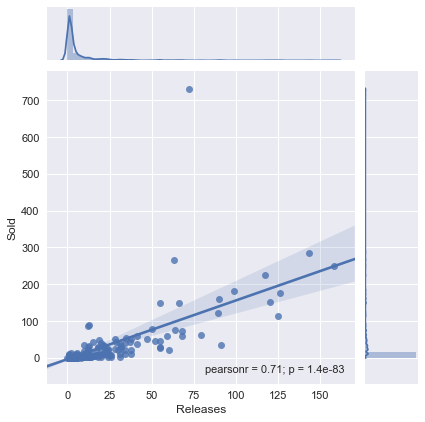

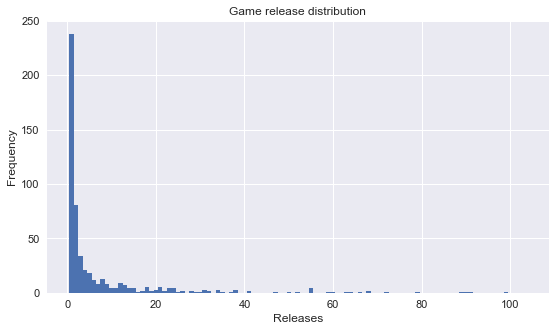

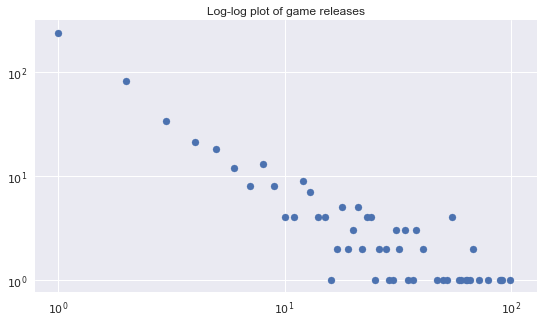

4799


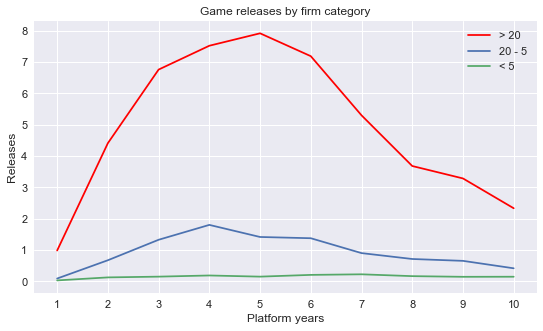

In [14]:
avgs = [get_developer_behavior(generations[i],g=i) for i in range(2,8)]

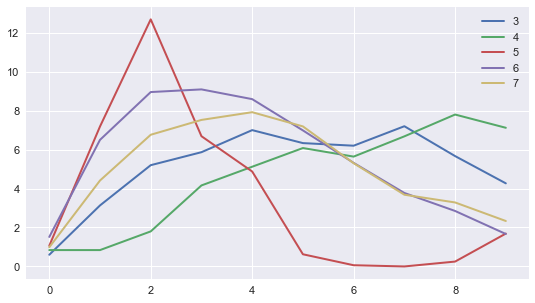

In [15]:
g = 3
for i in avgs[1:]:
    plt.plot(i,label=str(g),linewidth=2)
    g+=1
plt.legend()
plt.show()

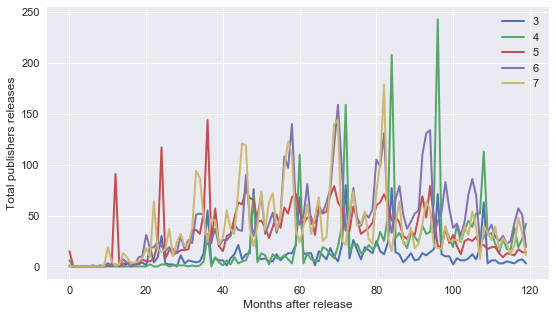

In [16]:
for g in range(3,8):
    gen6 = data[data.Console.isin(generations[g])]
    gen6_rel = []
    gen6yrs = [i for i in list(gen6.Year) if i > 1983]
    if g == 5:
        gen6yrs = [i for i in list(gen6.Year) if i > 1990]
    for y in range(min(gen6yrs),min(gen6yrs)+10):
        for m in range(1,13):
            gy = gen6[gen6.Year == y]
            gm = gy[gy.Month == m]
            gen6_rel.append(len(gm))
    plt.plot(gen6_rel,label=g,linewidth=2)
plt.legend()
plt.xlabel('Months after release')
plt.ylabel('Total publishers releases')
plt.show()

1978


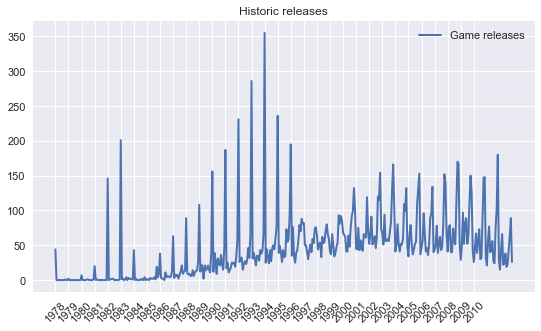

In [17]:
gen6 = data[data.Console.isin(home_console)]
gen6_rel = []
gen6yrs = [i for i in list(gen6.Year) if i > 1977]
print min(gen6yrs)
for y in range(min(gen6yrs),min(gen6yrs)+35):
    for m in range(1,13):
        gy = gen6[gen6.Year == y]
        gm = gy[gy.Month == m]
        gen6_rel.append(len(gm))
plt.title('Historic releases')
plt.plot(gen6_rel,linewidth=2,label='Game releases')
plt.legend()
plt.xticks(np.arange(0,385,12),np.arange(1978,2011),rotation=45)
plt.show()

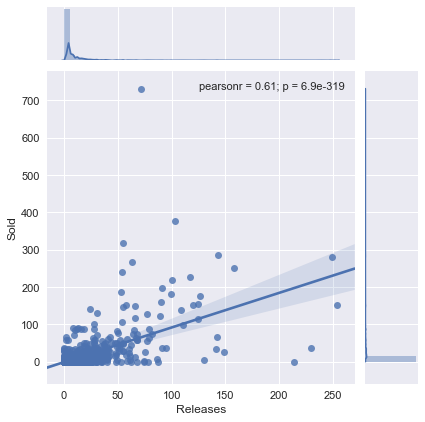

In [18]:
hcdata = tdf[tdf.Console.isin(home_console)]
sns.jointplot('Releases','Sold',data=hcdata,kind='reg')

In [19]:
data.head()

,Console,CriticScore,Date,Developer,Game,Id,JAP,NA,Other,PAL,Publisher,Total,UserScore,VGCScore,Day,Month,Year,WW
0,Wii,NAN,19th Nov 06,Nintendo EAD,Wii Sports,1,29.02,82.65,3.77,41.36,Nintendo,NAN,7.7,NAN,19,11,2006,156.80
1,NES,NAN,18th Oct 85,Nintendo EAD,Super Mario Bros.,2,3.58,40.24,6.81,29.08,Nintendo,NAN,10,NAN,18,10,1985,79.71
2,Wii,8.7,27th Apr 08,Nintendo EAD,Mario Kart Wii,3,12.92,35.90,3.80,15.84,Nintendo,9.1,8.2,NAN,27,4,2008,68.46
3,Wii,8.8,26th Jul 09,Nintendo EAD,Wii Sports Resort,4,10.98,32.90,3.29,15.61,Nintendo,8.8,8,NAN,26,7,2009,62.78
4,GB,NAN,30th Sep 98,Game Freak,Pok�mon Red / Green / Blue Version,5,8.89,31.37,10.22,11.27,Nintendo,NAN,9.4,NAN,30,9,1998,61.75


In [20]:
data_gens = []
for cons in data.Console:
    try:
        data_gens.append(console_gen[cons])
    except:
        data_gens.append(None)
data['Generation'] = data_gens
        

In [21]:
hcdf = data[data.Generation > 0]
print len(hcdf)
hcdf = hcdf[hcdf.NA > 0]
print len(hcdf)
hcdf.head()

23261
11524


,Console,CriticScore,Date,Developer,Game,Id,JAP,NA,Other,PAL,Publisher,Total,UserScore,VGCScore,Day,Month,Year,WW,Generation
0,Wii,NAN,19th Nov 06,Nintendo EAD,Wii Sports,1,29.02,82.65,3.77,41.36,Nintendo,NAN,7.7,NAN,19,11,2006,156.80,7.0
1,NES,NAN,18th Oct 85,Nintendo EAD,Super Mario Bros.,2,3.58,40.24,6.81,29.08,Nintendo,NAN,10,NAN,18,10,1985,79.71,3.0
2,Wii,8.7,27th Apr 08,Nintendo EAD,Mario Kart Wii,3,12.92,35.90,3.80,15.84,Nintendo,9.1,8.2,NAN,27,4,2008,68.46,7.0
3,Wii,8.8,26th Jul 09,Nintendo EAD,Wii Sports Resort,4,10.98,32.90,3.29,15.61,Nintendo,8.8,8,NAN,26,7,2009,62.78,7.0
7,Wii,5.3,12th Feb 07,Nintendo EAD,Wii Play,8,9.18,28.92,2.93,13.96,Nintendo,4.5,5.9,NAN,12,2,2007,54.99,7.0


In [22]:
gen_distro = {i:[] for i in set(hcdf.Generation)}
print gen_distro

{2.0: [], 3.0: [], 4.0: [], 5.0: [], 6.0: [], 7.0: [], 8.0: []}


In [23]:
for i in set(hcdf.Generation):
    gendata = hcdf[hcdf.Generation == i]
    genpublish = list(set(gendata.Publisher))
    for p in genpublish:
        pubdata = gendata[gendata.Publisher == p]
        gen_distro[i].append(sum(list(pubdata.NA)))
        

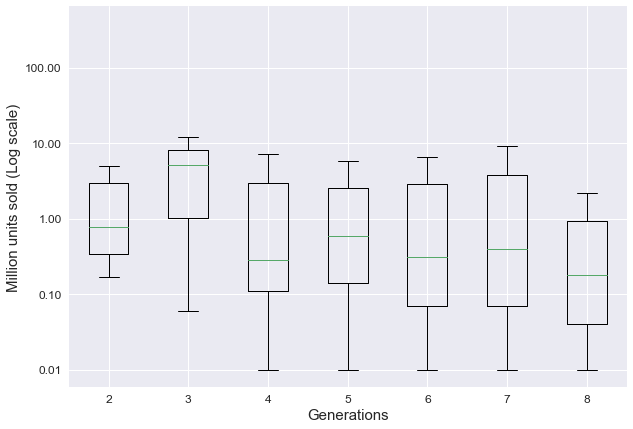

In [24]:
from matplotlib import ticker as tkr
rcParams['figure.figsize'] = 10, 7
rcParams["legend.handletextpad"] = 2
rcParams["legend.frameon"] = False
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

fig1, ax1 = plt.subplots()
ax1.boxplot(gen_distro.values())
ax1.set_yscale('log')
ax1.set_yticks([0.01, 0.1, 1,10,100])
ax1.get_yaxis().set_major_formatter(tkr.ScalarFormatter())
plt.xticks(np.arange(1,8),np.arange(2,9))
ax1.set_xlabel('Generations')
ax1.set_ylabel('Million units sold (Log scale)')
#ax1.set_title('Publisher sales distribution by Generation')
plt.show()


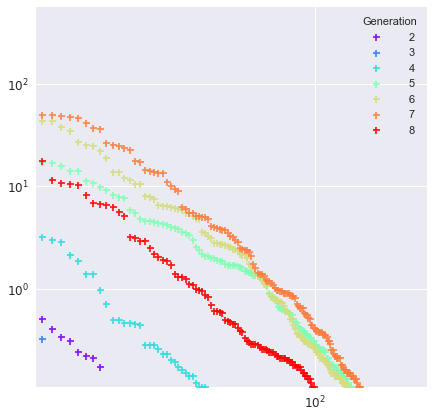

In [25]:
gen_distro = {i:[] for i in set(hcdf.Generation)}
for i in range(2,9):
    gendata = hcdf[hcdf.Generation == i]
    genpublish = list(set(gendata.Publisher))
    for p in genpublish:
        pubdata = gendata[gendata.Publisher == p]
        gen_distro[i].append(sum(list(pubdata.NA)))

plt.figure(figsize=(7,7))
cc,cmap=get_cmap([0]*6)
for i in gen_distro.values():
    ii = sorted(i,reverse=True)
    plt.scatter(np.arange(0,len(ii)),ii,color=cmap.to_rgba(cc),alpha=0.9,marker='+',label=cc+2)
    cc+=1
plt.legend(loc=1,title='Generation')
#plt.yscale('log')
plt.loglog()
plt.ylim=(0,100)
plt.xlim=(0,500)
plt.show()

In [26]:
gendistro = {g:[v] for g,v in gen_distro.items()}
dataplot = pd.DataFrame.from_dict(gendistro,orient='index')
sns.boxplot(x='0',data=dataplot)


ValueError: Could not interpret input '0'

In [27]:
dfpub

NameError: name 'dfpub' is not defined

In [28]:
publishers = {str(i):[str(i).replace(' ','')] if len(str(i)) < 20 else [str(i).split(' ')[0]] for i in list(set(hcdf.Publisher))}
for p in publishers.keys():
    dfpub = hcdf[hcdf.Publisher == p]
    
    #Releases
    publishers[p].append(len(dfpub.Game))  
    
    #Creation date
    try:
        publishers[p].append(min([y for y in dfpub.Year if y > 1972]))
    except:
        publishers[p].append(None)
        
    #Sales
    publishers[p].append(sum([float(i) for i in dfpub.WW if i > 0]))
    
    #Sales Post 2008 or generation 7 + 8
    salespost2008 = dfpub[dfpub.Generation > 6]
    publishers[p].append(sum([float(i) for i in salespost2008.WW if i > 0]))
    publishers[p].append(len([float(i) for i in salespost2008.WW if i > 0]))
    
    #Platforms released in
    platspost2008 = ['X360', 'Wii', 'XOne', 'WiiU', 'PS3', 'NS', 'PS4'] #list(set(hcdf[hcdf.Generation > 6].Console))
    for plat in platspost2008:
        if plat in list(salespost2008.Console):
            publishers[p].append(len([salespost2008[salespost2008.Console == plat]]))
        else:
            publishers[p].append(0)

In [29]:
pub_df = pd.DataFrame.from_dict(publishers,orient='index')
pub_df.columns = ['Name','Releases','Creation','Sales','Post08','Release08']+platspost2008
pub_df['Region'] = [None for i in range(len(pub_df))]

In [30]:
pub_df

,Name,Releases,Creation,Sales,Post08,Release08,X360,Wii,XOne,WiiU,PS3,NS,PS4,Region
MAGES,MAGES,1,2018.0,0.02,0.02,1,0,0,0,0,0,0,1,None
Naxat Soft,NaxatSoft,1,2008.0,0.02,0.00,0,0,0,0,0,0,0,0,None
Epoch,Epoch,8,1991.0,2.18,0.00,0,0,0,0,0,0,0,0,None
Hiromi,Hiromi,1,1998.0,0.02,0.00,0,0,0,0,0,0,0,0,None
Marvelous Interactive,Marvelous,16,2007.0,0.66,0.30,5,1,1,0,0,1,0,0,None
Conspiracy Entertainment,Conspiracy,40,2001.0,11.28,7.21,27,1,1,0,0,1,0,0,None
Magix,Magix,2,2003.0,0.65,0.00,0,0,0,0,0,0,0,0,None
2K Play,2KPlay,21,2008.0,13.51,11.48,14,1,1,0,0,0,0,0,None
Rising Star,RisingStar,1,2011.0,0.09,0.09,1,1,0,0,0,0,0,0,None
Societa,Societa,1,1996.0,0.08,0.00,0,0,0,0,0,0,0,0,None


In [31]:
len(hcdf[hcdf.UserScore > 2])

11513

In [32]:
region = {'Japan':['Nintendo','Sega','Capcom','SquareEnix','Konami','Namco','Sony'],
            'North America':['Activision','Atari','Microsoft','EASports','ElectronicArts','THQ','RockstarGames'],
          'Europe':['Ubisoft']
         }
colors = {'Japan':'red','North America':'orange','Europe':'green',None:'blue'}

new_region = []
for i in list(pub_df.Name):
    temp = None
    for k,v in region.items():
        if i in v:
            temp = k
    new_region.append(temp)
pub_df['Region'] = new_region
pub_df = pub_df[pub_df.Creation > 1971]
pub_df.head()

,Name,Releases,Creation,Sales,Post08,Release08,X360,Wii,XOne,WiiU,PS3,NS,PS4,Region
MAGES,MAGES,1,2018.0,0.02,0.02,1,0,0,0,0,0,0,1,None
Naxat Soft,NaxatSoft,1,2008.0,0.02,0.00,0,0,0,0,0,0,0,0,None
Epoch,Epoch,8,1991.0,2.18,0.00,0,0,0,0,0,0,0,0,None
Hiromi,Hiromi,1,1998.0,0.02,0.00,0,0,0,0,0,0,0,0,None
Marvelous Interactive,Marvelous,16,2007.0,0.66,0.30,5,1,1,0,0,1,0,0,None


In [33]:
pub_df[pub_df.Name == 'Nintendo']

,Name,Releases,Creation,Sales,Post08,Release08,X360,Wii,XOne,WiiU,PS3,NS,PS4,Region
Nintendo,Nintendo,320,1983.0,1900.16,946.27,133,0,1,0,1,0,1,0,Japan


In [34]:
len(pub_df.Name)

523

133


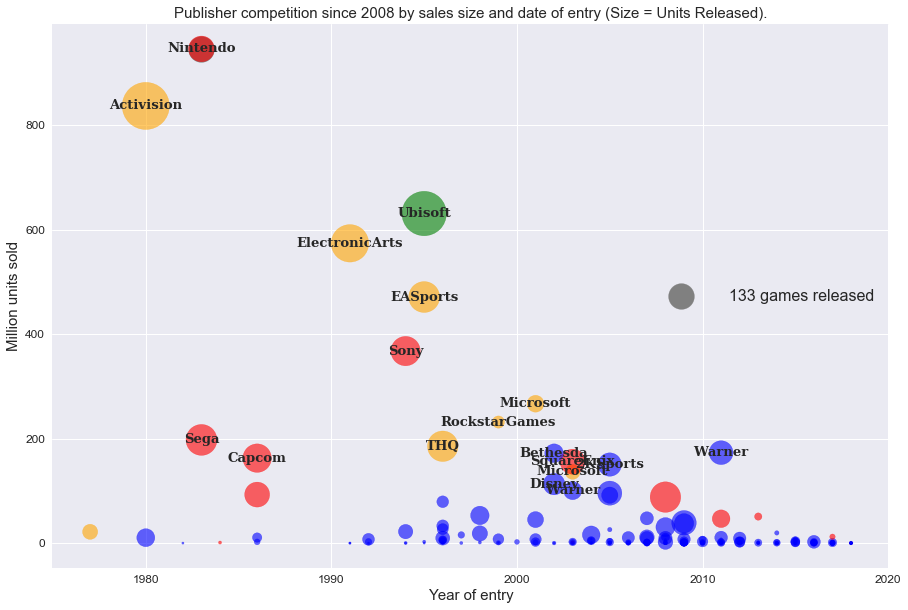

In [35]:
np_name = np.array(pub_df.Name)
np_releases = np.array(pub_df.Releases)
np_create = np.array(pub_df.Creation)
np_sales = np.array(pub_df.Sales)#/(2020-np.array(pub_df.Creation))


#post 2008
np_releases = np.array(pub_df.Release08)
np_sales = np.array(pub_df.Post08)

#alverre
np_releases = np.array(pub_df.Post08)
np_sales = np.array(pub_df.Release08)

rcParams['figure.figsize'] = 15, 10
rcParams["legend.handletextpad"] = 2
rcParams["legend.frameon"] = False
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.scatter(np_create[np_name == 'Nintendo'],np_releases[np_name == 'Nintendo'], s = np_sales[np_name == 'Nintendo']*5,
           alpha =1, label = str(np_sales[np_name == 'Nintendo'][0])+' games released', color='grey')
ax.scatter(np_create, np_releases , s = np_sales*5, alpha =0.6, color = [colors[r] for r in pub_df.Region])




alignment = {'horizontalalignment': 'center', 'verticalalignment': 'center'}
for i, txt in enumerate(np.array(pub_df.Name)):
    if np_releases[i] > 100:
        if txt == 'Nintendo':
            print(np_sales[i])
        t = plt.text(np_create[i], np_releases[i], txt, family='serif', weight='semibold', variant= 'normal',
                     size = 'large', **alignment)
        #ax.annotate(txt, (np_create[i], np_releases[i]), ha='center', va='center')

# Previous customizations
plt.xlabel('Year of entry')
plt.ylabel('Million units sold')
plt.title('Publisher competition since 2008 by sales size and date of entry (Size = Units Released).')
plt.legend(loc=7,fontsize=16)
plt.show()

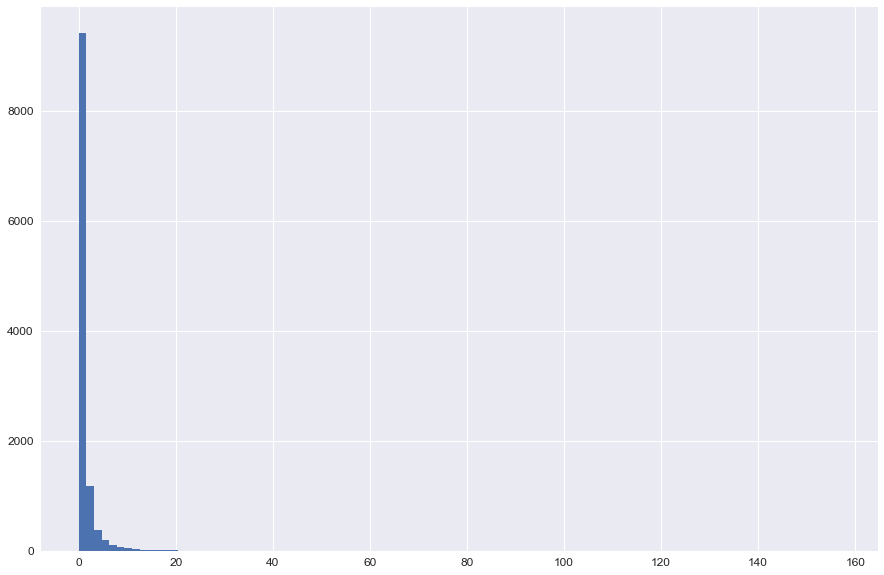

In [36]:
plt.hist(np.array(hcdf.WW),bins=100)
plt.show()

In [37]:
np_sales[np_name == 'Nintendo']

array([133], dtype=int64)

In [38]:
pub_df['Age'] = [2018-i for i in pub_df.Creation]

C:\Users\Lulin\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
#for regression, all platforms are used as dummy variablebut mayor platform 
test_df = pub_df[['Post08','Release08','Age']+platspost2008]
test_df.columns = ['Sales','Releases','Age']+platspost2008


In [40]:
print [len(test_df[test_df[plat] > 0]) for plat in platspost2008]

[122, 124, 86, 31, 118, 65, 149]


In [41]:
test_df.to_csv('PublishersTest.csv')

In [42]:
hcdf.to_pickle('Home Console (DataFrame)')

In [43]:
platdf = pd.read_pickle('Platform Sales DataFrame')

In [44]:
homeplatdf = platdf[platdf.Code.isin(home_console)]

In [45]:
homeplatdf = homeplatdf[['Platform','Gen','North America','Global','Month','Year','Code']]

In [46]:
hcdf = pd.read_pickle('Home Console (DataFrame)')

In [47]:
na_sales,publishers,developer = [],[],[]
for c in homeplatdf.Code:
    na_sales.append(sum(list(hcdf[hcdf.Console == c].NA)))
    publishers.append(len(set(hcdf[hcdf.Console == c].Publisher)))
    developer.append(len(set(hcdf[hcdf.Console == c].Developer)))
homeplatdf['Publishers'] = publishers
homeplatdf['Developer'] = developer
homeplatdf['NA_GameSales'] = na_sales
homeplatdf['User/Publisher'] = [str(float(i[2]*1000000)/(i[7]+0.0001)) for i in homeplatdf.values]
homeplatdf['User/Developer'] = [str(float(i[2]*1000000)/(i[8]+0.0001)) for i in homeplatdf.values]

In [48]:
homeplatdf = homeplatdf[:-5]

In [49]:
targetgens = homeplatdf[homeplatdf.Gen.isin(range(3,8))]

In [50]:
targetgens

,Platform,Gen,North America,Global,Month,Year,Code,Publishers,Developer,NA_GameSales,User/Publisher,User/Developer
0,PlayStation 2 (PS2),6.0,53.65,157.68,Mar,2000.0,PS2,175,682,1266.27,306571.253388,78665.677615
3,PlayStation (PS),5.0,38.94,104.25,Dec,1994.0,PS,136,476,734.48,286323.31888,81806.7055028
4,Wii (Wii),7.0,45.51,101.64,Nov,2006.0,Wii,124,553,916.00,367015.833052,82296.5493135
5,PlayStation 3 (PS3),7.0,29.42,86.90,Nov,2006.0,PS3,118,454,960.50,249321.822609,64801.747841
6,Xbox 360 (X360),7.0,49.11,85.80,Nov,2005.0,X360,123,500,986.14,399267.968075,98219.980356
11,Nintendo Entertainment System (NES),3.0,33.49,61.91,Oct,1985.0,NES,15,26,255.88,2232651.78232,1288071.96895
12,Super Nintendo Entertainment System (SNES),4.0,22.88,49.10,Nov,1990.0,SNES,52,99,200.64,439999.153848,231110.877666
14,Nintendo 64 (N64),5.0,20.11,32.93,Sep,1996.0,N64,55,139,222.92,365635.698844,144676.154909
15,Sega Genesis (GEN),4.0,16.98,29.54,Jan,1989.0,GEN,8,16,30.86,2122473.46908,1061243.36723
17,Xbox (XB),6.0,15.77,24.65,Nov,2001.0,XB,74,367,259.41,213107.820125,42970.0155395


In [51]:
print np.mean([float(i) for i in list(targetgens['User/Developer'])])
print np.mean([float(i) for i in list(targetgens['User/Publisher'])])


260541.49789172306
576974.3353689308


In [52]:
gen_totals = {}
for g in range(3,9):
    gen_totals[g] = sum(list(platdf[platdf.Gen == g].Global))*1000000

In [53]:
gen_totals

{3: 66209999.99999999,
 4: 207950000.0,
 5: 147120000.0,
 6: 293780000.0,
 7: 510060000.00000006,
 8: 227549999.99999997}

In [54]:
len([i for i in hcdf[hcdf.Generation == g].WW if i != 'NAN'])

1580

In [55]:
game_totals = {}
for g in range(3,9):
    game_totals[g] = sum(list(hcdf[hcdf.Generation == g].WW))*1000000

In [56]:
game_totals

{3: 506430000.00000006,
 4: 465670000.00000006,
 5: 1937109999.999989,
 6: 3276379999.9999733,
 7: 5420140000.000086,
 8: 1801119999.9999838}

In [57]:
plat_weeks = 6*365*12*4

In [58]:
for k,v in game_totals.items():
    print k,v/plat_weeks

3 4817.6369863
4 4429.88964992
5 18427.6065449
6 31167.9984779
7 51561.4535769
8 17133.9421613


In [59]:
pub_df['Log(Sales)'] = [np.log(i) for i in pub_df.Sales]

C:\Users\Lulin\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


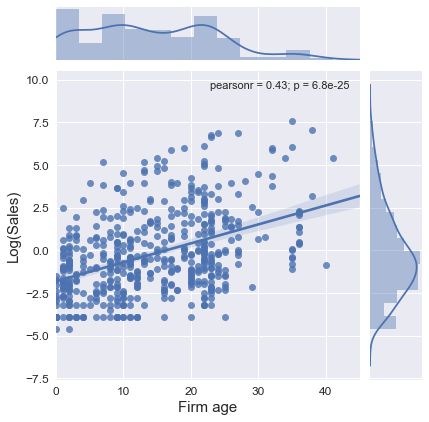

In [60]:
sns.jointplot('Age','Log(Sales)',data=pub_df,kind="reg",xlim=(0,45))
#plt.yticks()
plt.xlabel('Firm age')
plt.show()

In [103]:
gen_pubs ={i:[] for i in [1,2,3,4,5,6,7,8]}
for p in pub_df.index:
    this_pub = hcdf[hcdf.Publisher == p]
    for g in [1,2,3,4,5,6,7,8]:
        gen_pubs[g].append(float(sum(list(this_pub[this_pub.Generation == g].NA))))
   

1
1
8
1
16
40
2
21
1
1
8
4
5
1
1
1
1
1
1
114
1
1
2
5
16
3
6
1
7
2
49
3
28
1
2
45
9
2
7
1
53
2
1
2
1
2
3
6
479
7
158
2
1
1
34
10
2
3
2
1
7
1
16
2
1
1
1
41
61
1
23
738
5
1
81
1
5
182
28
7
1
7
2
11
3
1
2
3
2
1
11
10
3
189
3
2
522
1
5
1
10
1
1
1
2
2
2
1
38
1
1
5
4
2
1
1
3
2
5
13
6
1
1
74
1
1
17
1
4
1
1
1
14
5
3
2
7
35
1
4
2
16
5
25
35
4
9
1
6
554
3
2
9
15
1
1
7
1
3
1
10
27
6
51
3
18
37
12
4
4
1
6
1
1
1
1
1
15
3
448
32
4
75
1
1
9
19
1
3
1
1
1
2
2
3
5
503
12
2
108
14
2
3
12
32
3
5
130
1
9
7
8
1
1
1
2
2
1
17
28
1
29
13
20
1
9
212
3
2
1
10
117
12
20
11
12
1
3
1
1
1
40
1
1
1
9
3
1
2
2
7
6
2
1
2
15
2
3
63
6
15
1
1
7
46
2
2
7
1
10
5
3
1
1
84
1
6
1
1
7
3
2
43
1
1
1
2
23
2
2
1
1
2
36
2
2
3
5
1
11
218
3
19
36
2
2
11
88
1
1
12
1
17
145
1
71
2
1
2
2
3
2
1
2
59
5
5
1
2
2
2
18
121
1
5
1
1
1
1
10
3
1
2
102
1
1
1
478
2
6
2
6
2
1
10
3
1
1
87
1
4
1
6
33
2
2
1
1
1
1
12
1
2
13
1
5
3
3
11
111
6
1
16
1
23
2
20
34
36
1
156
1
4
1
3
419
1
1
121
11
1
32
5
1
76
1
17
3
2
2
2
4
1
10
1
4
1
1
1
2
4
1
1
102
1
18
2
1
5
1


In [104]:
for g in gen_pubs.keys():
    pub_df['Gen'+str(g)] = gen_pubs[g]

C:\Users\Lulin\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


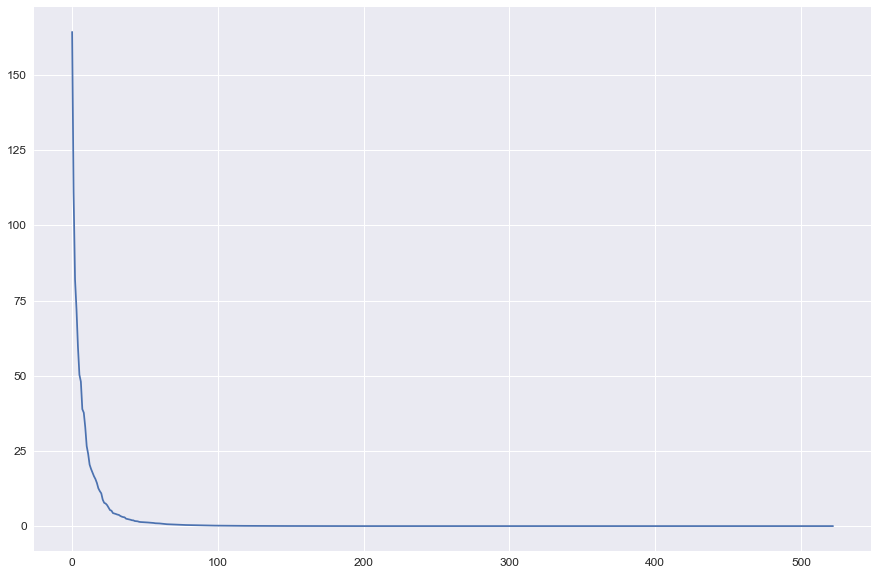

In [111]:
values = []
for g in [2,3,4,5,6,7,8]:
    pub_df = pub_df.sort_values(by='Gen'+str(g),ascending=False)    
    values.append(list(pub_df['Gen'+str(g)]))

mean_vals = np.mean(values,axis=0)
plt.plot(mean_vals)

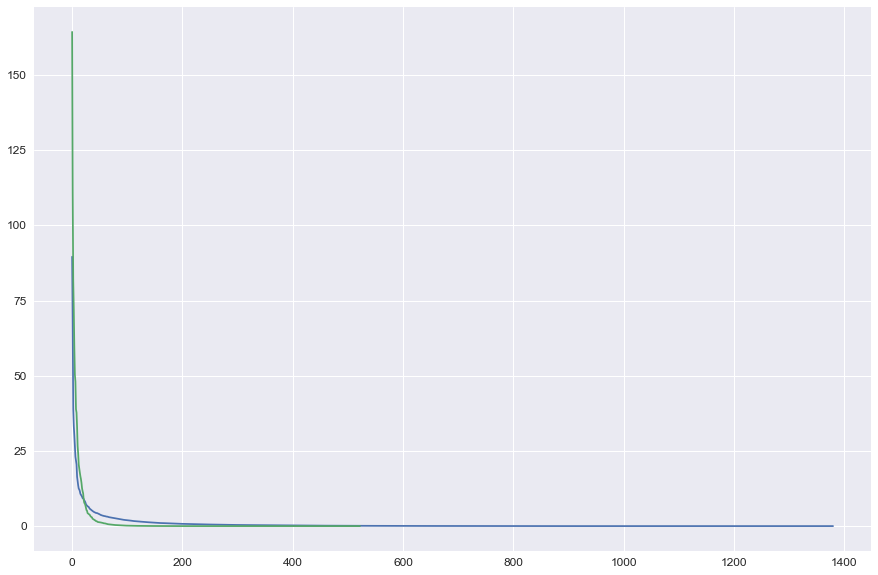

In [118]:
ddd = pd.read_pickle('Empirics_Parameter3')
mvs = pd.Series(mean_vals)
plt.plot(ddd)
plt.plot(mean_vals)
plt.show()

In [148]:
mean_vals_s = pd.Series(mean_vals)
mean_vals_s.to_pickle('Empirics_Parameter3')

In [149]:
values = []
for g in [3,4,5,6,7]:
    thisdf = platdf[platdf.Gen == g]
    thisdf = thisdf.sort_values(by='North America',ascending=False)
    values.append(np.array(list(thisdf['North America'])))
values = [np.array(list(i)+[0]*(6-len(i))) for i in values]

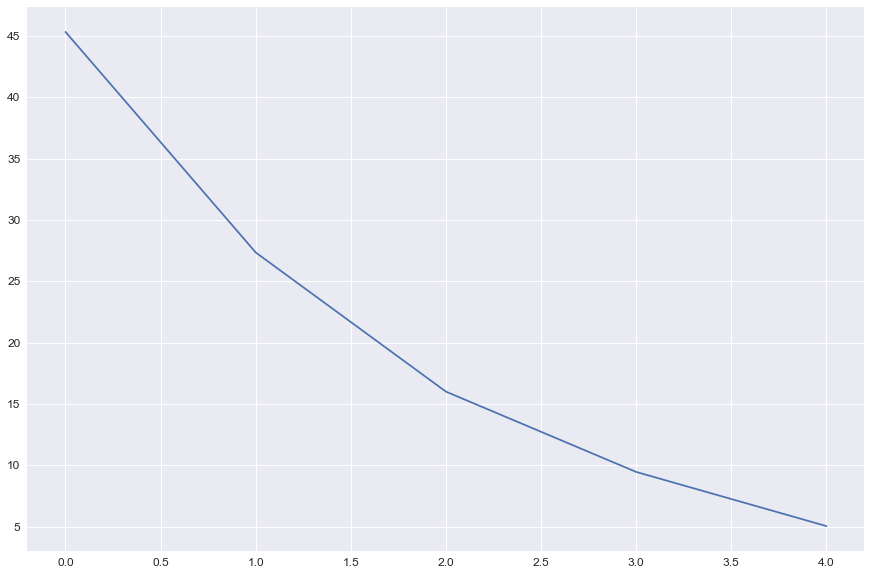

In [146]:
plats_vals = [float(i) for i in np.mean(values,axis=0) if i >0 ]
plt.plot(plats_vals)

In [147]:
plats_s = pd.Series(plats_vals)
plats_s.to_pickle('Empirics_Parameter1')

In [153]:
homeconsoles = list(set(hcdf.Console))
print homeconsoles

['DC', 'PS2', 'PS3', 'NES', 'PS4', 'PCE', 'X360', 'N64', 'SCD', 'NG', 'NS', 'GEN', 'SAT', '2600', 'PS', 'XB', 'XOne', 'GC', 'WiiU', '3DO', 'Wii', 'SNES']


In [161]:
#Do Releases per platform
gen_cons ={i:[] for i in [2,3,4,5,6,7,8]}
for h in homeconsoles:
    this_cons = hcdf[hcdf.Console == h]
    for g in [2,3,4,5,6,7,8]:
        releases_in_gen = len(this_cons[this_cons.Generation == g])
        if releases_in_gen > 0:
            gen_cons[g].append(releases_in_gen)

In [169]:
rank = []
for vals in gen_cons.values():
    vals.sort(reverse=True)
    rank.append(vals+[0]*(5-len(vals)))
mean_rank = np.mean(rank,axis=0)

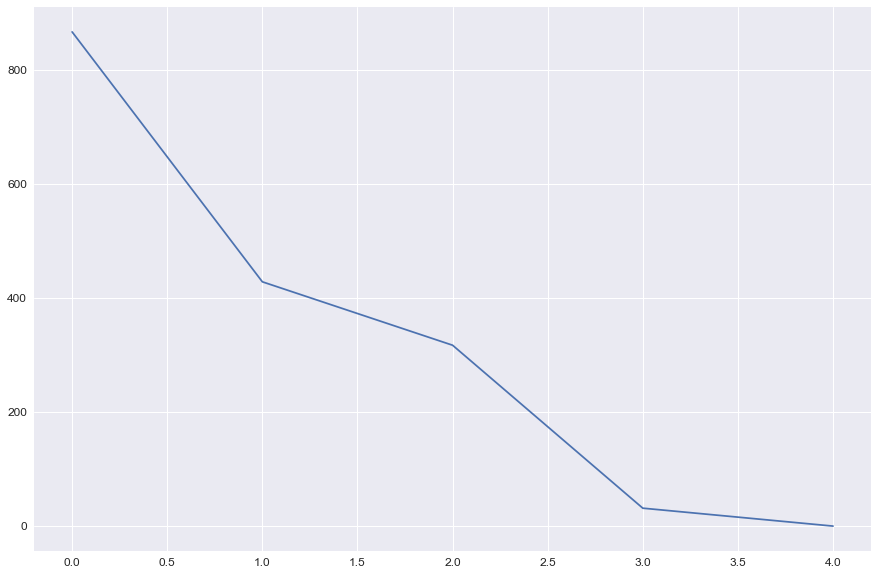

In [172]:
plt.plot(mean_rank)

In [173]:
mean_rank_s = pd.Series(mean_rank)
mean_rank_s.to_pickle('Empirics_Parameter4')